In [1]:
from sklearn.feature_extraction import DictVectorizer
from collections import Counter
import re
import random
import numpy as np


In [3]:
#opens the file, removes the header and puts each line into a list
def preprocess(file_name):
    data = []
    is_header = True
    with open(file_name) as file:
        for line in file:
            
            if(is_header):
                is_header = False
                continue
            
            line=line.strip().split("\t")
            
            data.append(line)
    
    return tuple(data);
train_data = preprocess("dev-raw.tsv")
test_data = preprocess("test-raw.tsv")
train_data[873]

['2874',
 'Sydney',
 '"\'utterly\' is now trending in #Sydney http://t.co/pCmfpRNn0r"']

In [33]:
#finds the frequency of each word
from collections import defaultdict

def create_freq_dict(train_data):
    all_words = defaultdict(int)

    for line in train_data:
        msg = re.sub("[^a-zA-Z+\s\d]", "", line[-1]).lower().split(" ")
        for word in msg:
            all_words[word.lower()] += 1
    return all_words
    
    



In [34]:
#creates the Word Locality Heuristic (wlh) by creating a dictionary of words, where each word 
#contains information in this format [score, freqency, location most frequent]
from collections import defaultdict

def create_wlh(train_data):
    
    all_words = create_freq_dict(train_data)
    
    locs = ["Brisbane", "Perth", "Melbourne", "Sydney"]

    bris_freq = defaultdict(int)
    perth_freq = defaultdict(int)
    melb_freq = defaultdict(int)
    syd_freq = defaultdict(int)

    #counts the words for each class
    for line in train_data:

        msg = line[-1]
        msg = re.sub("[^a-zA-Z+\s\d]", "", msg).lower().split(" ")

        if (line[1] == "Brisbane"): 
            for word in msg:
                bris_freq[word] += 1
        elif (line[1] == "Perth"): 
            for word in msg:
                perth_freq[word] += 1
        elif (line[1] == "Melbourne"): 
            for word in msg:
                melb_freq[word] += 1
        elif (line[1] == "Sydney"): 
            for word in msg:
                syd_freq[word] += 1

    #finds the highest frequency word for each location
    wlh = defaultdict(list)
    wlh_score = 0;
    for word in all_words.keys():
        max_freq = max(bris_freq[word], perth_freq[word], melb_freq[word], syd_freq[word])

        if (word in bris_freq.keys()) and (max_freq == bris_freq[word]):
            max_freq_state = "Brisbane"
        elif (word in perth_freq.keys()) and (max_freq == perth_freq[word]):
            max_freq_state = "Perth"
        elif (word in melb_freq.keys()) and (max_freq == melb_freq[word]):
            max_freq_state = "Melbourne"
        elif (word in syd_freq.keys()) and (max_freq == syd_freq[word]):
            max_freq_state = "Sydney"
            
        #creates and returns the the word into the required wlh format
        wlh_score = max_freq/float(all_words[word])
        wlh[word].append(wlh_score)
        wlh[word].append(max_freq)
        wlh[word].append(max_freq_state)
    return wlh


In [36]:
#creates Location Lexicon which has this required form [score, freq, location most frequent].
#The word is only added to the location Lexicon if it meets frequency and score cutoffs
#p = number of times used
#h = threshhold score
def create_location_lexi(wlh, freq_cutoff, score_cutoff):

    location_lexi = defaultdict(list)

    for word, wlh_info in wlh.items():
        
        score = wlh_info[0]
        freq = wlh_info[1]
        loc = wlh_info[2]
    
        if score >= score_cutoff and freq >= freq_cutoff:
            location_lexi[word] = wlh_info
    return location_lexi

In [37]:
#predicts the location of origin of a message using the Location Lexicon
def location_lexi_predict(msg, location_lexi):
    
    #generate a random prediction
    #used for when no message after removing non-alphanumerics or when there are no words in the lexicon
    locs = ["Brisbane", "Perth", "Melbourne", "Sydney"]
    random_locs_int = random.randint(0,3)
    random_loc = locs[random_locs_int]
    
    lexi_max_score = 0;
    lexi_state_freq = defaultdict(int)
    
    msg = re.sub("[^a-zA-Z+\s\d]", "", msg).lower().split(" ")

    
    #checks if message is empty after removing non-alphabeticals
    if not msg:
        return random_loc
    
    is_first = True
    for word in msg:
        if word in location_lexi.keys():
            word_loc = location_lexi[word][2]
            lexi_state_freq[word_loc] += 1
            
            #update max score in the lexicon
            if location_lexi[word][0] > lexi_max_score:
                lexi_max_score = location_lexi[word][0]
                lexi_max_score_state = word_loc
            
            #update max freq location
            if(lexi_state_freq[word_loc] == max(lexi_state_freq.values())):
                lexi_max_freq_state = word_loc
            elif is_first:
                lexi_max_freq_state = word_loc
            
            is_first = False
        else:
            continue
    
    #case where all the words in the message are not in the lexicon
    if is_first:
        return random_loc;
            
    #counts the number of states that has the same frequency of number of lexicons in the message
    num_max_score = 0
    for i in lexi_state_freq.values():
        if(i == max(lexi_state_freq.values())):
            num_max_score += 1
    
    #when there are 2 or more states with the same number of lexicons within the message, return the lexicon with the
    #highest score
    if num_max_score >= 2:
        return lexi_max_score_state
    else:
        return lexi_max_freq_state
    

        

In [38]:

#tests for the functions above (using the train data as the test data)
"""all_words = create_freq_dict(train_data)
print(all_words["kellyfrye"])
wlh = create_wlh(train_data)
print(wlh["is"])
print(wlh_predict("is"))
location_lexi = create_location_lexi(wlh, 20, 0.7)
print(len(location_lexi))
print("pressure" in location_lexi.keys())
print(location_lexi)
print(location_lexi_predict("temp murder performing", create_location_lexi(wlh, 20, 0.7)))"""

'all_words = create_freq_dict(train_data)\nprint(all_words["kellyfrye"])\nwlh = create_wlh(train_data)\nprint(wlh["is"])\nprint(wlh_predict("is"))\nlocation_lexi = create_location_lexi(wlh, 20, 0.7)\nprint(len(location_lexi))\nprint("pressure" in location_lexi.keys())\nprint(location_lexi)\nprint(location_lexi_predict("temp murder performing", create_location_lexi(wlh, 20, 0.7)))'

In [40]:
#finds the accuracy given cutoffs
from sklearn.model_selection import train_test_split

def EM_location_lexi(freq_cutoff, score_cutoff):
    acc = []
    precision_acc = []
    
    #uses random sampling to train 80% of the data and tests the other 20%
    for i in range(5):
        rand_num = random.randint(1,100000)
        train_samp, test_samp = train_test_split(train_data, test_size=0.2, random_state=rand_num)
        wlh = create_wlh(train_samp)
        location_lexi = create_location_lexi(wlh, freq_cutoff, score_cutoff)
        
        #generates accuracy using the testing data
        counter = 0
        correct = 0
        for line in test_samp:
            pred = location_lexi_predict(line[-1], location_lexi)
            counter += 1
            if(pred == line[1]):
                correct += 1
            
        acc.append(correct/float(counter))
        
    return np.mean(acc)


In [41]:
#find best freq and score cutoff
acc_cutoff_info_arr = []
for freq_cutoff in range(5, 105, 5):
    for score_cutoff in np.arange(0.25, 0.67, 0.03):
        acc_cutoff_info = []
        acc = EM_location_lexi(freq_cutoff, score_cutoff)
        acc_cutoff_info.append(freq_cutoff)
        acc_cutoff_info.append(score_cutoff)
        acc_cutoff_info.append(acc)
        acc_cutoff_info_arr.append(acc_cutoff_info)
        print("freq cutoff: {}, score cutoff: {}, accuracy: {}".format(freq_cutoff, score_cutoff, acc))
    

freq cutoff: 5, score cutoff: 0.25, accuracy: 0.3470257234726688
freq cutoff: 5, score cutoff: 0.28, accuracy: 0.3606377277599142
freq cutoff: 5, score cutoff: 0.31000000000000005, accuracy: 0.38062700964630225
freq cutoff: 5, score cutoff: 0.3400000000000001, accuracy: 0.38606645230439446
freq cutoff: 5, score cutoff: 0.3700000000000001, accuracy: 0.3880493033226152
freq cutoff: 5, score cutoff: 0.40000000000000013, accuracy: 0.3827706323687031
freq cutoff: 5, score cutoff: 0.43000000000000016, accuracy: 0.3827170418006431
freq cutoff: 5, score cutoff: 0.4600000000000002, accuracy: 0.38269024651661315
freq cutoff: 5, score cutoff: 0.4900000000000002, accuracy: 0.38729903536977495
freq cutoff: 5, score cutoff: 0.5200000000000002, accuracy: 0.3838424437299035
freq cutoff: 5, score cutoff: 0.5500000000000003, accuracy: 0.3793676312968917
freq cutoff: 5, score cutoff: 0.5800000000000003, accuracy: 0.3772240085744909
freq cutoff: 5, score cutoff: 0.6100000000000003, accuracy: 0.37971596998

freq cutoff: 40, score cutoff: 0.25, accuracy: 0.29997320471597
freq cutoff: 40, score cutoff: 0.28, accuracy: 0.3212754555198285
freq cutoff: 40, score cutoff: 0.31000000000000005, accuracy: 0.3215434083601286
freq cutoff: 40, score cutoff: 0.3400000000000001, accuracy: 0.3218917470525188
freq cutoff: 40, score cutoff: 0.3700000000000001, accuracy: 0.3227759914255091
freq cutoff: 40, score cutoff: 0.40000000000000013, accuracy: 0.3180600214362272
freq cutoff: 40, score cutoff: 0.43000000000000016, accuracy: 0.32092711682743835
freq cutoff: 40, score cutoff: 0.4600000000000002, accuracy: 0.320042872454448
freq cutoff: 40, score cutoff: 0.4900000000000002, accuracy: 0.3188906752411576
freq cutoff: 40, score cutoff: 0.5200000000000002, accuracy: 0.31339764201500536
freq cutoff: 40, score cutoff: 0.5500000000000003, accuracy: 0.31704180064308685
freq cutoff: 40, score cutoff: 0.5800000000000003, accuracy: 0.3137459807073955
freq cutoff: 40, score cutoff: 0.6100000000000003, accuracy: 0.31

freq cutoff: 75, score cutoff: 0.25, accuracy: 0.29062165058949624
freq cutoff: 75, score cutoff: 0.28, accuracy: 0.3091639871382637
freq cutoff: 75, score cutoff: 0.31000000000000005, accuracy: 0.31264737406216503
freq cutoff: 75, score cutoff: 0.3400000000000001, accuracy: 0.3051714898177921
freq cutoff: 75, score cutoff: 0.3700000000000001, accuracy: 0.30337620578778135
freq cutoff: 75, score cutoff: 0.40000000000000013, accuracy: 0.3040728831725616
freq cutoff: 75, score cutoff: 0.43000000000000016, accuracy: 0.3112540192926045
freq cutoff: 75, score cutoff: 0.4600000000000002, accuracy: 0.3095123258306538
freq cutoff: 75, score cutoff: 0.4900000000000002, accuracy: 0.3061629153269025
freq cutoff: 75, score cutoff: 0.5200000000000002, accuracy: 0.3082261521972133
freq cutoff: 75, score cutoff: 0.5500000000000003, accuracy: 0.30897642015005355
freq cutoff: 75, score cutoff: 0.5800000000000003, accuracy: 0.3106377277599143
freq cutoff: 75, score cutoff: 0.6100000000000003, accuracy: 

In [51]:
#finds highest accuracy
curr_max_acc = 0
for a_acc_cutoff_info_arr in acc_cutoff_info_arr:
    if a_acc_cutoff_info_arr[2] > curr_max_acc:
        curr_max_acc = a_acc_cutoff_info_arr[2]
print(curr_max_acc)

0.3880493033226152


In [42]:
freq_cutoff_list = []
score_cutoff_list = []
acc_list = []

#stores mean accuracy for each value of freq and score
freq_cutoff_mean_acc = []
score_cutoff_mean_acc = []

sum_freq_cutoff_acc = 0
counter = 0
for one_acc_cutoff_info_arr in acc_cutoff_info_arr:
    counter += 1
    
    freq_cutoff_list.append(one_acc_cutoff_info_arr[0])
    score_cutoff_list.append(one_acc_cutoff_info_arr[1])
    acc_list.append(one_acc_cutoff_info_arr[2])

    sum_freq_cutoff_acc += one_acc_cutoff_info_arr[2]
    
    if(counter % 15 == 0):
        freq_cutoff_mean_acc.append(sum_freq_cutoff_acc/float(15))
        sum_freq_cutoff_acc = 0

print(len(score_cutoff_list))
print(len(freq_cutoff_mean_acc))
sum_score_cutoff_acc = 0
counter = 0

for i in range(15):
    sum_score_cutoff_acc = 0
    for j in range(20):
        sum_score_cutoff_acc += acc_list[(15 * j) + i ]
    score_cutoff_mean_acc.append(sum_score_cutoff_acc/float(20))
#print(freq_cutoff_list)
#print(score_cutoff_mean_acc)

300
20


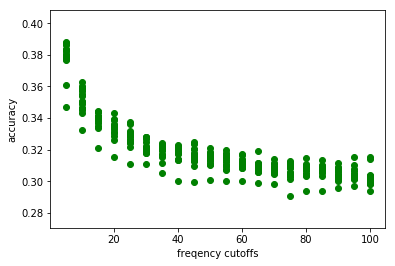

In [43]:
#graph of change in accuracy versus change in frequency cutoffs
import matplotlib.pyplot as plt
plt.scatter(freq_cutoff_list,acc_list,color='green',label='freq cutoff')

plt.xlabel("freqency cutoffs")
plt.ylabel("accuracy")
plt.show()

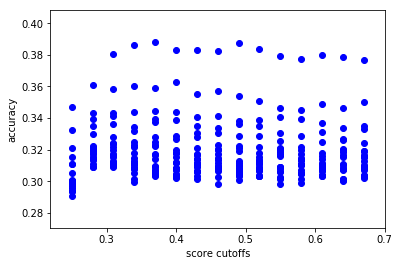

In [44]:
#graph of change in accuracy versus change in score cutoffs
plt.scatter(score_cutoff_list,acc_list,color='blue',label='score cutoff')
plt.xlabel("score cutoffs")
plt.ylabel("accuracy")
plt.show()

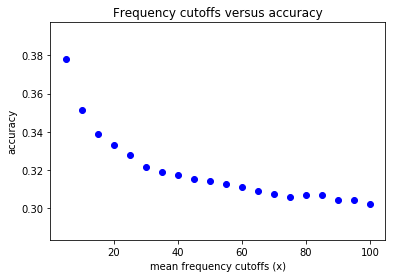

In [76]:
#graph of change in accuracy versus change in mean frequency cutoffs
plt.scatter(sorted(list(set(freq_cutoff_list))),freq_cutoff_mean_acc,color='blue',label='score cutoff')
plt.title("Frequency cutoffs versus accuracy")
plt.xlabel("mean frequency cutoffs (x)")
plt.ylabel("accuracy")
plt.show()

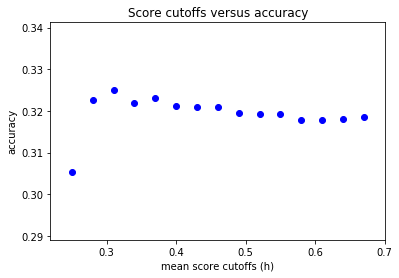

In [77]:
#graph of change in accuracy versus change in mean score cutoffs
plt.scatter(sorted(list(set(score_cutoff_list))),score_cutoff_mean_acc,color='blue',label='score cutoff')
plt.title("Score cutoffs versus accuracy")
plt.xlabel("mean score cutoffs (h)")
plt.ylabel("accuracy")
plt.show()

In [56]:
#error analysis of location lexicon
locs = ["Brisbane", "Perth", "Melbourne", "Sydney"]
locs = [[0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0]]
rand_num = random.randint(1,100000)
train_samp, test_samp = train_test_split(train_data, test_size=0.2, random_state=rand_num)
#print(train_samp[0])
#print(train_samp[1])
wlh = create_wlh(train_samp)
location_lexi = create_location_lexi(wlh, 5, 0.37)
for line in test_samp:
    pred = location_lexi_predict(line[-1], location_lexi)
    if pred == "Brisbane":
        if line[1] == "Brisbane":
            locs[0][0] += 1
        if line[1] == "Perth":
            locs[0][1] += 1
        if line[1] == "Melbourne":
            locs[0][2] += 1
        if line[1] == "Sydney":
            locs[0][3] += 1
    if pred == "Perth":
        if line[1] == "Brisbane":
            locs[1][0] += 1
        if line[1] == "Perth":
            locs[1][1] += 1
        if line[1] == "Melbourne":
            locs[1][2] += 1
        if line[1] == "Sydney":
            locs[1][3] += 1
    if pred == "Melbourne":
        if line[1] == "Brisbane":
            locs[2][0] += 1
        if line[1] == "Perth":
            locs[2][1] += 1
        if line[1] == "Melbourne":
            locs[2][2] += 1
        if line[1] == "Sydney":
            locs[2][3] += 1
    if pred == "Sydney":
        if line[1] == "Brisbane":
            locs[3][0] += 1
        if line[1] == "Perth":
            locs[3][1] += 1
        if line[1] == "Melbourne":
            locs[3][2] += 1
        if line[1] == "Sydney":
            locs[3][3] += 1
print(locs)

[[772, 430, 484, 479], [338, 761, 375, 376], [304, 338, 703, 335], [395, 359, 371, 644]]


In [74]:
#kaggle submission
import csv
output = [["Id", "Class"]]

wlh = create_wlh(train_data)
location_lexi = create_location_lexi(wlh, 5, 0.37)

test_data = preprocess("test-raw.tsv")
for line in test_data:
    inst = []
    pred = location_lexi_predict(line[-1], location_lexi)
    inst.append(line[0])
    inst.append(pred)
    output.append(inst)
csv_file = open("trungl2.csv", "w", newline = '')
writer = csv.writer(csv_file)
writer.writerows(output)
csv_file.close()
